In [277]:

import numpy as np
import os
import typing
import matplotlib.pyplot as plt


import networkx as nx
import cvxpy as cp
import torch
import torch.nn as nn
import random
from itertools import chain
from sklearn.model_selection import train_test_split
from torchsummary import summary
import sys
import io
import copy
import time
import torch
from torch.utils import data as torch_data
import pickle
import itertools
import warnings
from numpy import linalg as LA
from sklearn import preprocessing
from cvxpylayers.torch.cvxpylayer import CvxpyLayer
from torch.nn import init

In [278]:
training_data = []

#inci_matrix = torch.tensor([ [-1,-1,-1,0,0,0,0,0],
  # [1,0,0,-1,0,-1,0,0],
             #  [0,1,0,1,1,0,-1,0],
               
             #  [0,0,1,0,-1,0,0,-1],
            #   [0,0,0,0,0,1,1,1] 
             #  ],dtype=torch.float32)
inci_matrix = pickle.load( open( "matrix_{}b{}.p".format(80,130), "rb" ) )



while len(training_data) != 4000:
    
    z = torch.tensor([float(random.uniform(0.001, 1)) for i in range(130)])
    #z = torch.tensor([e1,e2,e3, e4, e5, e6, e7, e8])
    training_data.append(z)
training_data = torch.stack(training_data)


In [279]:
def cvx_py(A, pred):
   
    warnings.filterwarnings('ignore')
    
    
    eps = 0.5
    
    batch_s, edges  = pred.shape
   
    
    n,m = A.shape
    target = torch.zeros((batch_s, edges))
    
    #print(target.shape)
    c = cp.Parameter(m)
    #c = c.detach().numpy()
    b = np.zeros(n)
    b[0] = -1
    b[n-1] = 1
    x = cp.Variable(shape=m)
    constr = [x>=0, x <= 1,
             A*x == b]
    
  
    
    problem  = cp.Problem(cp.Minimize(c @ x ),constr)
    cvxlayer = CvxpyLayer(problem, parameters=[c], variables=[x])
  
   
    solutions = lambda z: cvxlayer(z)[0] #, args = {'tol':1e-10})[0]
    index = 0
    for x in pred:
        
         
        #print(x)
       # print(x)
        
            #sol = solutions(x)
        target[index] = solutions(x)
        
        #print(problem.value)
        index += 1
    
    return torch.Tensor(target)

In [280]:
def calc_violations(inc_matrix, selected_edges):
    #viol = 0
    viol_lst = []
    n,m = inc_matrix.shape
    b = np.zeros(n)
    # these are flipped to get 0 for violations, original are the opposite 
    b[0] = -1
    b[n-1] = 1
    
    batch_size, null = selected_edges.shape
    
    for i in selected_edges:
      #torch.unsqueeze(i,1)
      #print(i.shape)
      viol = 0
      
      a = torch.matmul(inci_matrix,i)
      #print(a.shape)
     # print(a.shape)
      #print(b.shape)
      c = a - b 
      for values in c:
        viol += torch.abs(values) 
      
      
      
      for j in i:
        if j < 0:
          viol += torch.abs(j)
        elif j > 1:
          viol += torch.abs(j-1)
      viol_lst.append(viol)
      
    #print(viol_lst)
      
    return  max(viol_lst), sum(viol_lst)/len(viol_lst)   

In [281]:
def regret_cvxpy(y_true, y_hat,cvx):
    A = inci_matrix    
    y_true_decision = cvx(A,y_true)
    y_hat_decision = cvx(A,y_hat)
    
    
    objective_true = (y_true * y_true_decision).sum(1)
    objective_hat =  (y_true * y_hat_decision).sum(1)
    
   # print(objective_true.shape)
   # print(objective_hat.shape)
    regret = torch.mean(objective_hat - objective_true)
   # print(regret.shape)
    return regret

In [282]:
def pred_net_data_generation(inputs):
    
    data = []
    target = []

    N,M  = inputs.shape
    
    A = torch.rand((M, M))
   
    print("Condition number: ",LA.cond(A))

    A_Inv = torch.linalg.inv(A)
    alpha = 0.05 # perturbation amplitude

    
    for i in inputs:
        target.append(i)
        x = torch.nn.functional.normalize(torch.matmul(A_Inv,i), dim=0, p=2)
        data.append(x)
        
    
    return data, target

In [283]:
#print(training_data)
x_nn, y_nn = pred_net_data_generation(training_data)

x_nn = torch.stack(x_nn)
y_nn = torch.stack(y_nn)

x_nn = preprocessing.normalize(x_nn)
y_nn = preprocessing.normalize(y_nn)
#print(x_nn[0])
#print(x_nn.shape)

Condition number:  555871.5


In [284]:
seed_random = 9999
np.random.seed(seed_random)
x_train, x_test, y_train, y_test = train_test_split(x_nn, y_nn, test_size=0.25, train_size=0.75, random_state=seed_random, shuffle=True)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, train_size=0.8, random_state=seed_random, shuffle=True)

print('shapes of train, validation, test data', x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)

shapes of train, validation, test data (2400, 130) (2400, 130) (600, 130) (600, 130) (1000, 130) (1000, 130)


In [285]:
params = {'iterations': 1000,'batch_size': 100, 'input_size': 130, 'hidden_units_1': 100, 'hidden_units_2': 200, 'hidden_units_3': 250, 'hidden_units_4': 300, 'hidden_units_5': 250, 'hidden_units_6': 200, 'hidden_units_7': 100, 'do_1': 0.2, 'do_2': 0.1, 'do_3': 0.05, 'output_size': 130, 'lr': 0.001, 'min_lr': 1e-05, 'max_lr': 0.001, 'epochs': 30, 'lr_sched': 'clr', 'lr_sched_mode': 'triangular', 'gamma': 0.95}

In [286]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

trainset = torch_data.TensorDataset(torch.as_tensor(x_train, dtype=torch.float, device=device), 
torch.as_tensor(y_train, dtype=torch.float, device=device))
train_dl = torch_data.DataLoader(trainset, batch_size=params['batch_size'], drop_last=True)

val_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_cv, dtype=torch.float, device=device), 
torch.as_tensor(y_cv, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

test_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_test, dtype=torch.float, device=device), 
torch.as_tensor(y_test, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

device: cpu


In [287]:

def init_weights(net, init_type='normal', init_gain=0.02):

    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming_uniform':
                nn.init.kaiming_uniform_(m.weight.data, mode='fan_in', nonlinearity='relu')

                #init.kaiming_uniform(m.weight.data, a=0, mode='fan_in')
                #init.kaiming_uniform(m.bias.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
                #init.orthogonal_(m.bias.data, gain=init_gain)
                
            elif init_type == 'kaiming_normal':
                nn.init.kaiming_normal_(m.weight.data, mode='fan_in', nonlinearity='relu')

            
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find(
                'BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)


In [288]:
torch.manual_seed(9999)
def get_model():
    """
    creates a PyTorch model. Change the 'params' dict above to 
    modify the neural net configuration.
    """
    model = torch.nn.Sequential(
        torch.nn.Linear(params['input_size'], params['hidden_units_1']),
        torch.nn.BatchNorm1d(params['hidden_units_1']),
         torch.nn.Dropout(p=params['do_1']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_1'], params['hidden_units_2']),
        torch.nn.BatchNorm1d(params['hidden_units_2']),
         torch.nn.Dropout(p=params['do_2']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_2'], params['hidden_units_3']),
        torch.nn.BatchNorm1d(params['hidden_units_3']),
         torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_3'], params['hidden_units_4']),
        torch.nn.BatchNorm1d(params['hidden_units_4']),
        torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_4'], params['hidden_units_5']),
        torch.nn.BatchNorm1d(params['hidden_units_5']),
        torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_5'], params['hidden_units_6']),
        torch.nn.BatchNorm1d(params['hidden_units_6']),
        torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_6'], params['hidden_units_7']),
        torch.nn.BatchNorm1d(params['hidden_units_7']),
        torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_7'], params['output_size']),
       # torch.nn.Sigmoid(),
        # torch.nn.Softplus(),
    )
    model.to(device)
    return model

#def mse_viol(pred, target):
    

model = get_model()
#best_model = copy.deepcopy(model)
initialize_model = True
if initialize_model:
    init_weights(model, 'xavier')

print('model loaded into device=', next(model.parameters()).device)

# this is just to capture model summary as string
old_stdout = sys.stdout
sys.stdout = buffer = io.StringIO()

summary(model, input_size=(params['input_size'], ))

sys.stdout = old_stdout
model_summary = buffer.getvalue()
#print('model-summary\n', model_summary)
# later this 'model-summary' string can be written to tensorboard

#lr_reduce_patience = 20
#lr_reduce_factor = 0.1

loss_fn = nn.MSELoss()  

# optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9, dampening=0, weight_decay=0, nesterov=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


initialize network with xavier
model loaded into device= cpu


In [289]:
#early_stop_patience = 10
#min_val_loss = -10
#patience_counter = 0
#patience = 10

best = 10000.0
patience = 20
fails = 0
flag = False


train_losses = []
val_losses = []

regret_lst = []

#l1_error = []

#avg_violations = []
#max_violations = []

#l1_loss_fn = nn.L1Loss()

train_iterator = itertools.cycle(train_dl)

val_iter = itertools.cycle(val_dl)

#flow_viol_lst = []
#selection_viol_lst = []



for iteration in range(0, params['iterations']):
  # loop over the dataset multiple times
  
  print("------------------------------------iteration: {}".format(iteration))
    #running_loss = 0.0
   
    
    
  model.train()
  
  #train_iterator = itertools.cycle(train_dl)
  data = next(iter(train_iterator))
  inputs, targets  = data
  
 
  
  
  prediction = model(inputs)
      
 
  loss = loss_fn(prediction,targets) 
    
    
  print("loss", loss.item())  
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
    
  train_losses.append(loss.item())
  
  with torch.no_grad(): 
    model.eval()
    val_data = next(iter(val_iter))
    
    val_inputs, val_targets = val_data
      
      #with torch.no_grad():
    print("eval----------")
    linear_layer_output_val = model(val_inputs)
    #max_v_, avg_v_ , a_v, b_v= calc_violations(inci_matrix, linear_layer_output_val.detach())
    val_loss = loss_fn(linear_layer_output_val, val_targets)# + 0.9*a_v + 0.1*b_v
    val_losses.append(val_loss.item())
    
    regret = regret_cvxpy(val_targets, linear_layer_output_val, cvx_py) 
    print("regret",regret.item())
    regret_lst.append(regret.item())
    print("eval done------")
  
  print(' train loss: {}, valid loss: {} '.format(round(loss.item(), 3), round(val_loss.item(),3)))
  
  if iteration%10==0:
    if val_loss < (best - 1e-5):
      print("\n UPDATE \n")
      best_model = copy.deepcopy(model)
      fails = 0
      best = val_loss
    else:
      fails = fails + 1
    if fails > patience:
      print("Early Stopping. Valid hasn't improved for {}".format(patience))
      flag = True
    if flag:
      break
    loss = 0
    val_loss = 0
   

print('Finished Training')

------------------------------------iteration: 0
loss 0.007890566252171993
eval----------
regret 0.5002570748329163
eval done------
 train loss: 0.008, valid loss: 0.008 

 UPDATE 

------------------------------------iteration: 1
loss 0.007891401648521423
eval----------
regret 0.526167631149292
eval done------
 train loss: 0.008, valid loss: 0.008 
------------------------------------iteration: 2
loss 0.007862705737352371
eval----------
regret 0.497384250164032
eval done------
 train loss: 0.008, valid loss: 0.008 
------------------------------------iteration: 3
loss 0.007876514457166195
eval----------
regret 0.4744223356246948
eval done------
 train loss: 0.008, valid loss: 0.008 
------------------------------------iteration: 4
loss 0.007855872623622417
eval----------
regret 0.46234431862831116
eval done------
 train loss: 0.008, valid loss: 0.008 
------------------------------------iteration: 5
loss 0.00788694154471159
eval----------
regret 0.4610692262649536
eval done------
 tra

KeyboardInterrupt: 

In [ ]:
test_iter = itertools.cycle(test_dl)
test_l2 = nn.MSELoss() 
#test_l1 = nn.L1Loss() 

l2_weights = []
l2_decision = []
test_viol = []
optimal_path_acc = []
inf_time = []

#optimal_path_acc = []

i =0 
for inputs, targets in test_iter:
    
    start = time.process_time()
    linear_layer_output = torch.nn.functional.normalize(model(inputs))
    selected_edges = cvx_py(inci_matrix,linear_layer_output)
    inf_time.append(time.process_time() - start)
    
    error_w = test_l2(linear_layer_output,targets)
    l2_weights.append(error_w)
    
    selected_edges_targets = cvx_py(inci_matrix,targets)
    error_d = test_l2(selected_edges,selected_edges_targets)
    l2_decision.append(error_d)
    
    vio = calc_violations(inci_matrix,selected_edges.detach())[1]
    test_viol.append(vio)
    #selected_edges = model_load(linear_layer_output)
    #selected_edges_targets = cvx_py(A,linear_layer_output) 
    i += 1
    if i == 5:
        break

print("l2 weights", sum(l2_weights)/len(l2_weights))
print("l2 decision", sum(l2_decision)/len(l2_decision))
print("inf time", sum(inf_time)/len(inf_time))
print("violations", sum(test_viol)/len(test_viol))

l2 weights tensor(0.0032, grad_fn=<DivBackward0>)
l2 decision tensor(0.0031, grad_fn=<DivBackward0>)
inf time 0.475
violations tensor(0.0002, dtype=torch.float64)


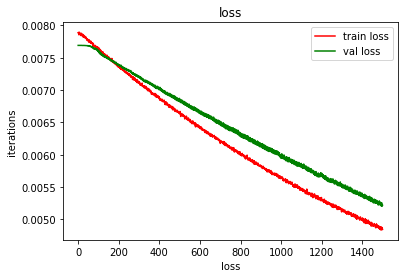

In [ ]:
plt.plot(train_losses,color='r', label='train loss')
plt.plot(val_losses, color='g', label='val loss')

plt.xlabel("loss")
plt.ylabel("iterations")
plt.title("loss")

plt.legend()

plt.show()
    

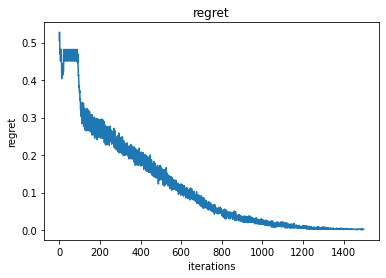

In [ ]:
plt.plot(regret_lst)
plt.ylabel('regret')
plt.xlabel('iterations')
plt.title("regret")
plt.show()